In [1]:
import sys
sys.path.append('../30_data_tools/')

In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from scipy.stats import chisquare
from sklearn import preprocessing
import re
from tqdm.auto import tqdm

In [3]:
from PIL import Image
import numpy as np
import sqlite3
from pathlib import Path
import json
from sklearn.preprocessing import LabelEncoder

In [4]:
from helper import load_dotenv
from get_labelstudio_data import get_results_of_project

In [5]:
def group_by( selection, group_by_features ):
    grouped = selection.loc[
        :,
        [*group_by_features,'label','mask_id']
    ].groupby([
        *[feature if feature != 'timestamp' else pd.Grouper(key='timestamp', freq="d") for feature in group_by_features],
        'label'
    ]).count().unstack('label')
    
    grouped.columns = [c[1] for c in grouped.columns]
    grouped.loc[:,'moire_ratio'] = grouped.checked_moire / (
        grouped.checked_moire + 
        grouped.checked_no_moire +
        grouped.ssim_no_moire
    )
    grouped.loc[:,'total_count'] = (
        grouped.checked_moire + 
        grouped.checked_no_moire +
        grouped.ssim_no_moire
    )

    return grouped

In [6]:
COLOR_MAP = {
    'checked_moire': '#db5561',
    'checked_no_moire': '#627a8e',
    'ssim_no_moire' : '#96aec3',
    True : '#db5561',
    False : '#84a6c4',
    "geprüft - Moiré" : '#db5561',
    "geprüft - kein Moiré" : '#627a8e',
    "ssim > 0,95" : '#96aec3'
}

COLOR_SEQUENCE = [
    '#627a8e',
    '#96aec3',
    '#cce5fc'
]

In [7]:
dotenv = load_dotenv()
con = sqlite3.connect( dotenv['DB_PATH'] )

In [8]:
masks = pd.merge(
    pd.read_sql(
        '''
            SELECT m.*, gi.timestamp, gi.config_name FROM mask m
            LEFT JOIN generic_image gi
            ON
            	m.job=gi.job AND
            	m.pdf_filename=gi.pdf_filename AND
            	m.idx = gi.idx AND 
            	m.variant_name = gi.variant_name AND 
            	m."type" = gi."type" 
        ''',
        con,
        parse_dates=['timestamp']
    ),
    pd.DataFrame(
        [(r['id'],r['labels'][0]) for r in get_results_of_project(2) if 'id' in r],
        columns=['mask_id','label']
    ),
    how="left",
    on="mask_id"
)

masks.loc[
    (pd.isna(masks.label)) & (masks.ssim >= 0.95),
    'label'
] = 'ssim_no_moire'

masks.loc[
    :,
    'pattern_shape'
] = masks.pattern.apply( lambda val: val.split('.')[-1] )

masks.loc[
    masks.pattern_shape == 'ellipse',
    'pattern_shape'
] = 'DIAMOND'

masks.loc[
    masks.pattern_shape == 'linie',
    'pattern_shape'
] = 'LINE'


# set plain or perlin
masks.loc[
    masks.pattern.str.startswith('plain_'),
    'cover_style'
] = 'plain'

masks.loc[
    masks.pattern.str.startswith('perlin_'),
    'cover_style'
] = 'perlin'

masks.cover_style.fillna('legacy', inplace=True)


masks.loc[
    masks.pattern.str.startswith('plain_'),
    'pattern_coverage'
] = masks.loc[
    masks.pattern.str.startswith('plain_')
].pattern.apply(lambda val: (10 - int(re.search(r'plain_(\d+)\.+',val).groups()[0])) / 10 )


masks = masks.loc[
    (pd.isna(masks.config_name) == False) &
    (masks.cover_style != 'legacy') &
    (masks.pattern_shape.isin(['LINE','CIRCLE','DIAMOND']))
]

In [9]:
attachment_dir = dotenv['ATTACHMENT_DIR'] / 'auswertung_moireerzeugung'

# Moirérate

In [10]:
masks.label.value_counts()

checked_no_moire    4281
ssim_no_moire       4160
checked_moire       1047
Name: label, dtype: int64

In [11]:
masks.label.value_counts().checked_moire / masks.shape[0]

0.11029179395343938

In [12]:
grouped_by_timestamp = masks.loc[
    :,
    ['timestamp','label','mask_id']
].groupby([
    pd.Grouper(key="timestamp", freq="d"),
    'label'
]).count().unstack('label')
grouped_by_timestamp.columns = [c[1] for c in grouped_by_timestamp.columns]
grouped_by_timestamp.loc[:,'moire_ratio'] = grouped_by_timestamp.checked_moire / (
    grouped_by_timestamp.checked_moire + 
    grouped_by_timestamp.checked_no_moire +
    grouped_by_timestamp.ssim_no_moire
)

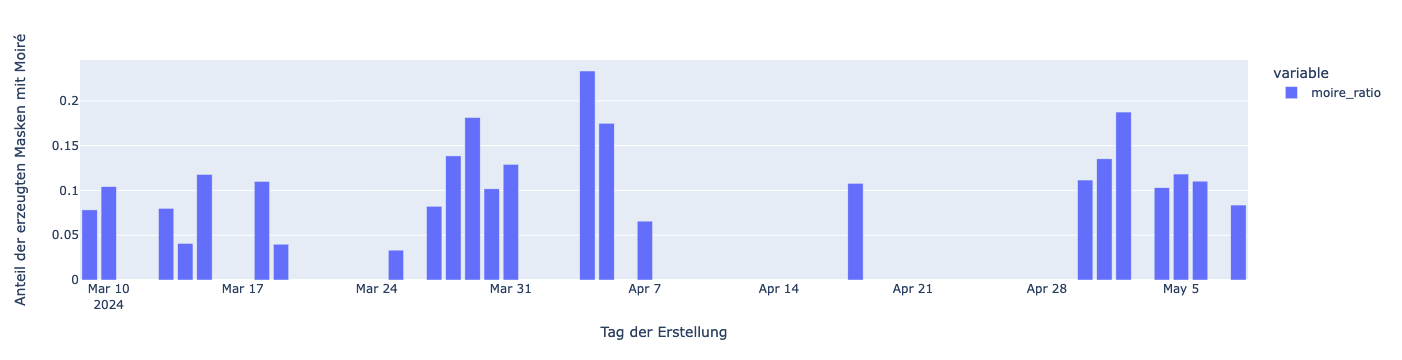

In [15]:
px.bar(
    grouped_by_timestamp.moire_ratio,
    labels={
        'timestamp' : 'Tag der Erstellung',
        'value' : 'Anteil der erzeugten Masken mit Moiré'
    }
)

In [14]:
grouped_by_config = group_by(
    masks,
    ['config_name']
).fillna(0)

In [16]:
grouped_by_config

,checked_moire,checked_no_moire,ssim_no_moire,moire_ratio,total_count
config_name,,,,,
deform,342,1063,1144,0.134170,2549
general,170,876,924,0.086294,1970
pullover,52,489,419,0.054167,960
rotate,244,927,826,0.122183,1997
stretch,239,926,847,0.118787,2012


In [ ]:
fig = px.bar(
    grouped_by_config.loc[
        :,
        ['checked_moire','checked_no_moire','ssim_no_moire']
    ],
    labels={
        'config_name' : 'verwendete Konfiguration',
        'value' : 'Anteil der erzeugten Masken mit Moiré',
        'variable' : 'Legende'
    },
    color_discrete_map=COLOR_MAP
)

#fig.update_layout(showlegend=False)
fig.write_image( attachment_dir / 'moire_rate_pro_config.jpg' )
fig.write_image( attachment_dir / 'moire_rate_pro_config.pdf' )
fig

# Gruppiert nach verwendetem Pattern

In [17]:
grouped_by_pattern = group_by(
    masks,
    ['pattern']
)

In [18]:
grouped_by_pattern

,checked_moire,checked_no_moire,ssim_no_moire,moire_ratio,total_count
pattern,,,,,
perlin_noise.5.33.0.150pli.ellipse,5.0,18.0,27.0,0.100000,50.0
perlin_noise.5.33.0.150pli.linie,3.0,9.0,15.0,0.111111,27.0
perlin_noise.5.33.0.df1;01.150pli.ellipse,6.0,17.0,28.0,0.117647,51.0
perlin_noise.5.33.0.df1;01.150pli.linie,2.0,19.0,18.0,0.051282,39.0
perlin_noise.5.33.0.df1;01.CIRCLE,5.0,47.0,42.0,0.053191,94.0
...,...,...,...,...,...
plain_8.DIAMOND,8.0,43.0,38.0,0.089888,89.0
plain_8.LINE,9.0,49.0,36.0,0.095745,94.0
plain_9.CIRCLE,3.0,36.0,46.0,0.035294,85.0


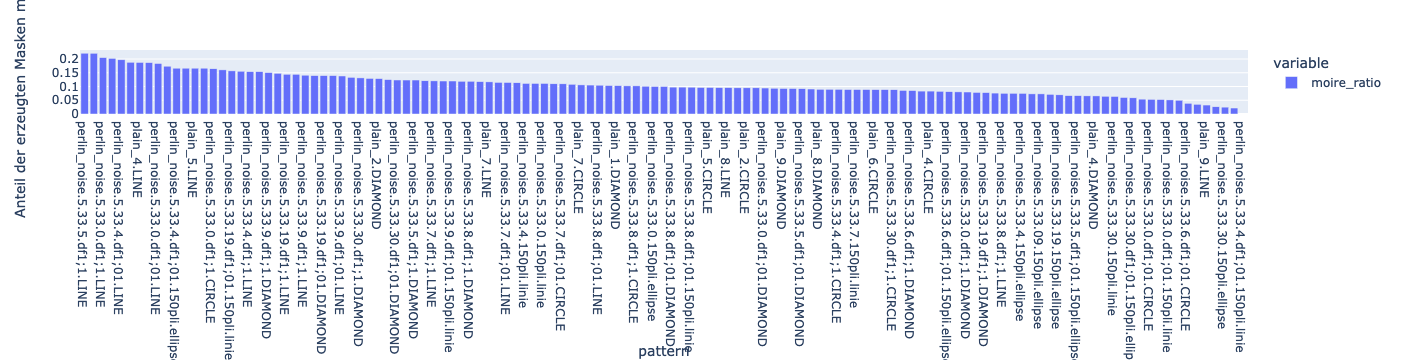

In [19]:
px.bar(
    grouped_by_pattern.sort_values('moire_ratio', ascending=False ).moire_ratio,
    labels={
        'timestamp' : 'Tag der Erstellung',
        'value' : 'Anteil der erzeugten Masken mit Moiré'
    }
)

## Perlin

In [40]:
grouped_by_perlin = group_by(
    masks,
    ['cover_style']
)
grouped_by_perlin.index = [
    'Perlin-Noise Verteilung',
    'gleichmäßige Verteilung'
]

In [41]:
grouped_by_perlin

,checked_moire,checked_no_moire,ssim_no_moire,moire_ratio,total_count
Perlin-Noise Verteilung,799,3175,3120,0.112630,7094
gleichmäßige Verteilung,248,1106,1040,0.103592,2394


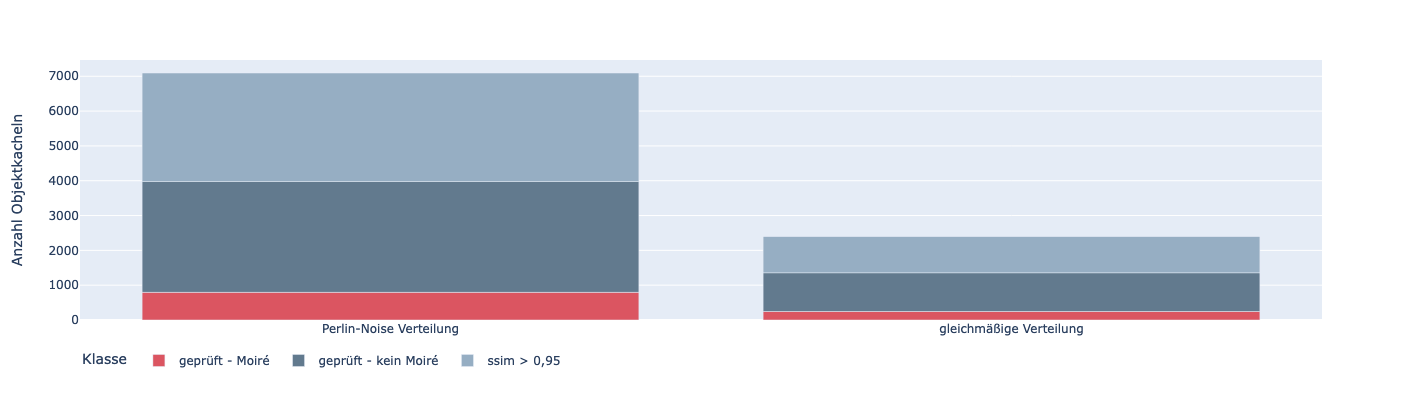

In [80]:
fig = px.bar(
    grouped_by_perlin.loc[
        :,
        ['checked_moire','checked_no_moire','ssim_no_moire']
    ].rename(
        columns={
            "checked_moire" : "geprüft - Moiré",
            "checked_no_moire" : "geprüft - kein Moiré",
            "ssim_no_moire" : 'ssim > 0,95'
        }
    ),
    labels={
        'index' : '',
        'value' : 'Anzahl Objektkacheln',
        'variable' : 'Klasse'
    },
    width=500,
    height=400,
    color_discrete_map=COLOR_MAP
)
fig.update_layout(legend={'orientation':'h'})
fig.write_image( attachment_dir / 'grouped_by_perlin.jpg' )
fig.write_image( attachment_dir / 'grouped_by_perlin.pdf' )

fig

## Form

In [35]:
grouped_by_shape_form = group_by(
    masks.loc[masks.pattern_shape.isin(['LINE','CIRCLE','DIAMOND'])],
    ['pattern_shape']
)
grouped_by_shape_form.index = ['Linie','Kreis','Karo']

In [36]:
grouped_by_shape_form

,checked_moire,checked_no_moire,ssim_no_moire,moire_ratio,total_count
Linie,243,1181,1108,0.095972,2532
Kreis,353,1620,1572,0.099577,3545
Karo,451,1480,1480,0.132219,3411


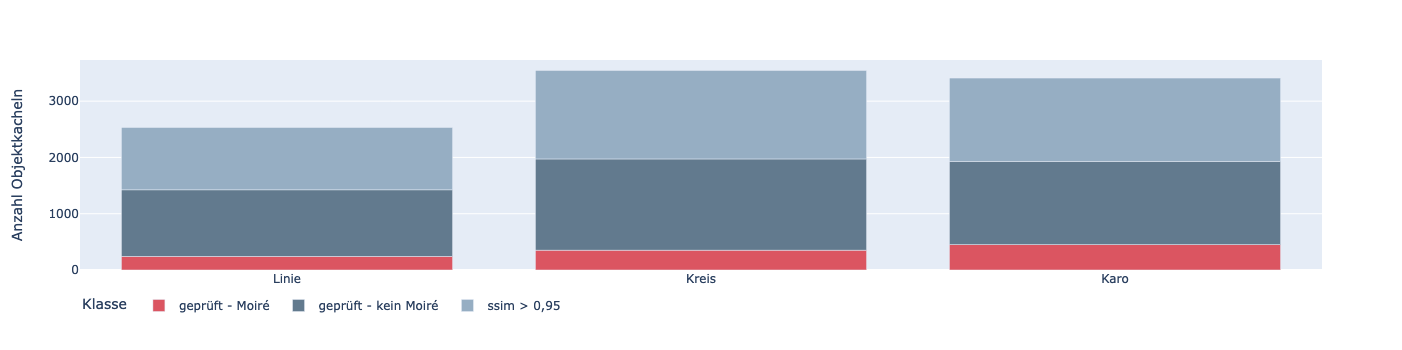

In [47]:
fig = px.bar(
    grouped_by_shape_form.loc[
        :,
        ['checked_moire','checked_no_moire','ssim_no_moire']
    ].rename(
        columns={
            "checked_moire" : "geprüft - Moiré",
            "checked_no_moire" : "geprüft - kein Moiré",
            "ssim_no_moire" : 'ssim > 0,95'
        }
    ),
    labels={
        'index' : '',
        'value' : 'Anzahl Objektkacheln',
        'pattern_shape' : 'Patternvorlage Mustergrundform',
        'variable' : 'Klasse'
    },
    width=500,
    height=350,
    color_discrete_map=COLOR_MAP
)
fig.update_layout(legend={'orientation':'h'})
fig.write_image( attachment_dir / 'grouped_by_shape_form.jpg' )
fig.write_image( attachment_dir / 'grouped_by_shape_form.pdf' )

fig

## Flächendeckung

In [51]:
grouped_by_pattern_coverage = group_by(
    masks.loc[masks.cover_style == 'plain'],
    ['pattern_coverage']
)

/var/folders/ns/b_3z05zx1bz71dzh3qcvtpyh0000gq/T/ipykernel_6156/1668801452.py:16: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



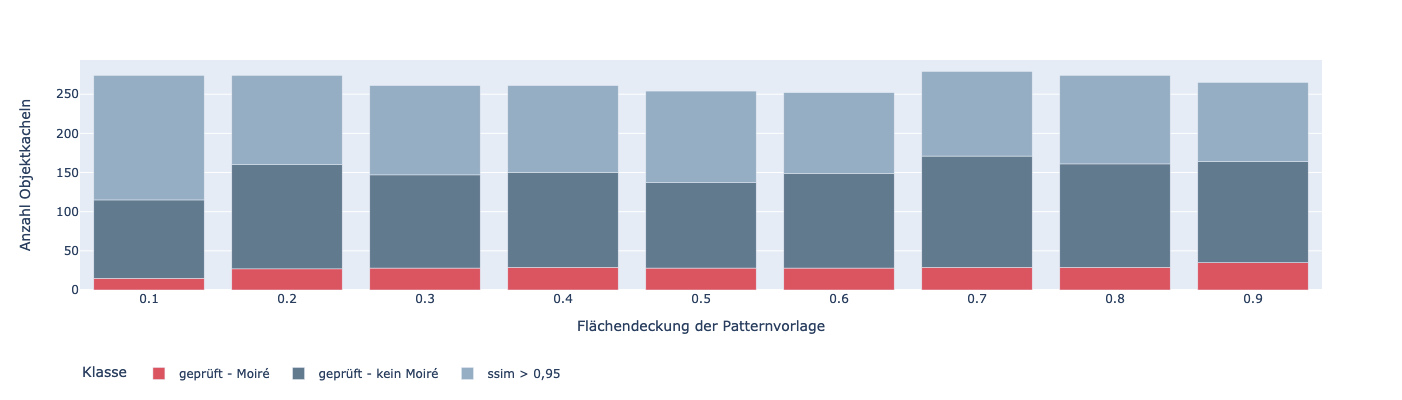

In [57]:
fig = px.bar(
    grouped_by_pattern_coverage.loc[
        :,
        ['checked_moire','checked_no_moire','ssim_no_moire']
    ].rename(
        columns={
            "checked_moire" : "geprüft - Moiré",
            "checked_no_moire" : "geprüft - kein Moiré",
            "ssim_no_moire" : 'ssim > 0,95'
        }
    ),
    labels={
        'value' : 'Anzahl Objektkacheln',
        'pattern_coverage' : 'Flächendeckung der Patternvorlage',
        'variable' : 'Klasse'
    },
    width=500,
    height=400,
    color_discrete_map=COLOR_MAP
)
fig.update_layout(legend={'orientation':'h', 'y' : -0.3})
fig.write_image( attachment_dir / 'grouped_by_pattern_coverage.jpg' )
fig.write_image( attachment_dir / 'grouped_by_pattern_coverage.pdf' )

fig

In [ ]:
grouped_by_pattern_coverage_and_shape = group_by(
    masks.loc[masks.pattern.str.startswith('plain_')],
    ['pattern_coverage','pattern_shape']
).fillna(0).moire_ratio.unstack('pattern_shape')

In [ ]:
px.line(
    grouped_by_pattern_coverage_and_shape
)

In [ ]:
grouped_by_pattern_coverage_and_shape

# Zusammehang: ssim und Flächedeckung

In [ ]:
def get_edge_share( row, edge_limit ):
    img = Image.open( row.img_path ).crop((
        row.bbox[0],
        row.bbox[1],
        row.bbox[0] + row.bbox[2],
        row.bbox[1] + row.bbox[3]
    ))

    k_separation = np.array(img)[:,:,3]
    relevant_part = k_separation[(k_separation < edge_limit) | (k_separation > (255 - edge_limit))]

    return relevant_part.shape[0] / (k_separation.shape[0] * k_separation.shape[1])

In [ ]:
data.loc[
    :,
    'edge_share'
] = data.apply( get_edge_share, args=(10,), axis=1 )

In [ ]:
edge_share = data.edge_share #returns a numpy array
edge_share_normalized = preprocessing.MinMaxScaler().fit_transform(edge_share.to_numpy().reshape((-1,1)))

ssim = data.ssim #returns a numpy array
ssim_normalized = preprocessing.MinMaxScaler().fit_transform(ssim.to_numpy().reshape((-1,1)))

In [ ]:
data.loc[
    :,
    'edge_share_normalized'
] = edge_share_normalized

data.loc[
    :,
    'ssim_normalized'
] = ssim_normalized

In [ ]:
data.loc[
    :,
    ['ssim','edge_share']
].corr()

In [ ]:
data.loc[
    :,
    ['ssim_normalized','edge_share_normalized']
].corr()

In [ ]:
data.iloc[0].img_path

# Kategorien von Masken

In [58]:
data = pd.merge(
    pd.read_sql(
        '''
            SELECT apm.*, m.overlay_intensity_K, m.ssim, m.bbox, gi."timestamp" FROM adjustment_per_mask apm 
            LEFT JOIN mask m
            ON
            	apm.pdf_filename = m.pdf_filename AND
            	apm.job = m.job AND
            	apm."type" = m."type" AND 
            	apm.variant_name = m.variant_name AND 
            	apm."method" = m."method" AND 
            	apm.idx = m.idx AND 
            	apm.mask_id = m.mask_id 
            LEFT JOIN generic_image gi 
            ON
            	apm.pdf_filename = gi.pdf_filename AND
            	apm.job = gi.job AND
            	apm."type" = gi."type" AND 
            	apm.variant_name = gi.variant_name AND 
            	apm."method" = gi."method" AND 
            	apm.idx = gi.idx 
        ''',
        con,
        parse_dates=['timestamp']
    ),
    pd.DataFrame(
        [(r['id'],r['labels'][0]) for r in get_results_of_project(2) if 'id' in r],
        columns=['mask_id','label']
    ),
    how="left",
    on="mask_id"
)

data.loc[
    (data.ssim > 0.95),
    'label'
] = 'ssim_no_moire'

In [59]:
from scipy import stats
from get_feature_importance_df import get_feature_importance_df, get_scale_data
from sklearn.ensemble import RandomForestClassifier

In [60]:
label_encoder = LabelEncoder()
label_encoder.fit(data.label.tolist())

LabelEncoder()

In [61]:
data.shape

(41026, 15)

In [62]:
data.loc[data.mask_id.str.startswith('temp_')].shape

(20662, 15)

In [ ]:
grouped_by_mask_id = data.loc[
    :,
    ['mask_id','job']
].groupby(
    'mask_id'
).count().rename(columns={'job':'adjustment_count'})

In [ ]:
fig = px.bar(
    grouped_by_mask_id.adjustment_count.value_counts().sort_index(),
    labels={
        "value" : 'Anzahl an Objektkacheln',
        'index' : 'Anzahl angewendete Effekte pro Objektkachel'
    },
    color_discrete_sequence=COLOR_SEQUENCE
)
fig.update_layout(showlegend=False)
fig.write_image( attachment_dir / 'effekte_pro_kachel.jpg' )

# Korrelationen

## Korrelation nach Features

In [87]:
def bayes( feature ):
    p_a = feature_available_frame.has_moire.mean()
    p_b = feature_available_frame.loc[:, feature].mean()

    p_b_a = feature_available_frame.loc[
        feature_available_frame[feature] == 1,
        'has_moire'
    ].mean()

    return (p_b_a * p_a) / p_b

In [82]:
feature_available_frame = data.loc[
    data.mask_id.isin(masks.mask_id),
    ['mask_id','adjustment','pdf_filename']
].groupby(['mask_id','adjustment']).count().unstack('adjustment').fillna(0)
feature_available_frame.columns = [c[1] for c in feature_available_frame.columns]

feature_available_frame.loc[
    :,
    'label'
] = feature_available_frame.apply( lambda row: masks.loc[masks.mask_id == row.name].iloc[0].label, axis=1 )
feature_available_frame.loc[:,'has_moire'] = feature_available_frame.label == 'checked_moire'

In [83]:
feature_probability_2d = []

for c1 in feature_available_frame.columns:
    if c1 not in ['label','has_moire']:
        for c2 in feature_available_frame.columns:
            if c2 not in ['label','has_moire', c1]:
                feature_probability_2d.append((
                    c1,
                    c2,
                    feature_available_frame.loc[
                        (feature_available_frame[c1] == 1) & 
                        (feature_available_frame[c2] == 1) & 
                        (feature_available_frame.label == 'checked_moire')
                    ].shape[0],
                    feature_available_frame.loc[
                        (feature_available_frame[c1] == 1) & 
                        (feature_available_frame[c2] == 1) & 
                        (feature_available_frame.label == 'checked_no_moire')
                    ].shape[0],
                    feature_available_frame.loc[
                        (feature_available_frame[c1] == 1) & 
                        (feature_available_frame[c2] == 1) & 
                        (feature_available_frame.label == 'ssim_no_moire')
                    ].shape[0],
                    feature_available_frame.loc[
                        (feature_available_frame[c1] == 1) & 
                        (feature_available_frame[c2] == 1)
                    ].shape[0] 
                ))

feature_probability_2d = pd.DataFrame(
    feature_probability_2d,
    columns=[
        'feature a',
        'feature b',
        'checked_moire',
        'checked_no_moire',
        'ssim_no_moire',
        'total_count'
    ]
).set_index(['feature a','feature b'])

feature_probability_2d.loc[
    :,
    'moire_rate'
] = feature_probability_2d.checked_moire / feature_probability_2d.total_count

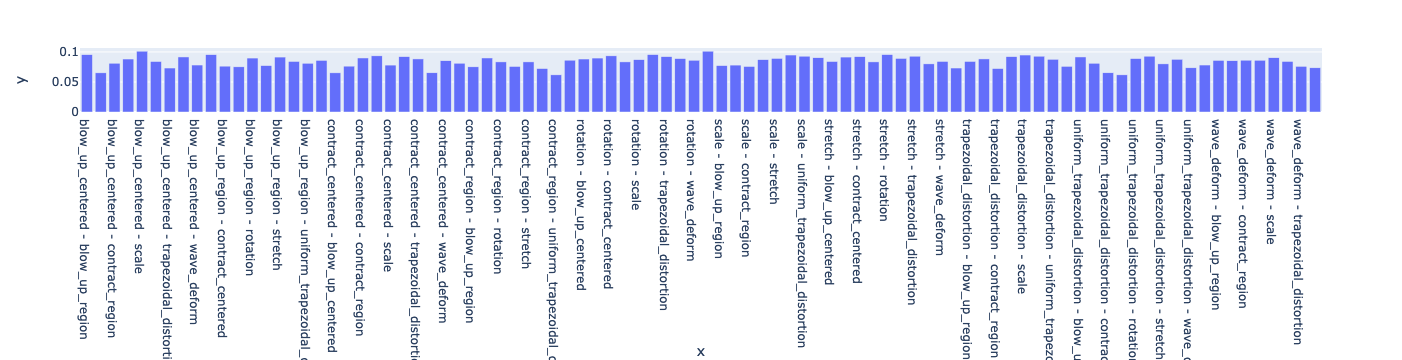

In [84]:
px.bar(
    x=feature_probability_2d.apply( lambda row: row.name[0] + ' - ' + row.name[1], axis=1 ),
    y=feature_probability_2d.moire_rate
)

In [92]:
feature_probability = []

for c in feature_available_frame.columns:
    if c not in ['label','has_moire']:
        feature_probability.append((
            c,
            feature_available_frame.loc[(feature_available_frame[c] == 1) & (feature_available_frame.label == 'checked_moire')].shape[0],
            feature_available_frame.loc[(feature_available_frame[c] == 1) & (feature_available_frame.label == 'checked_no_moire')].shape[0],
            feature_available_frame.loc[(feature_available_frame[c] == 1) & (feature_available_frame.label == 'ssim_no_moire')].shape[0],
            feature_available_frame.loc[feature_available_frame[c] == 1].shape[0],
            bayes(c)
        ))

feature_probability = pd.DataFrame(
    feature_probability,
    columns=[
        'feature',
        'checked_moire',
        'checked_no_moire',
        'ssim_no_moire',
        'total_count',
        'moire_probability'
    ]
).set_index('feature')

feature_probability.loc[
    :,
    'moire_rate'
] = feature_probability.checked_moire / feature_probability.total_count

feature_probability.index = [
    "kreisförmiges Expandieren",
    "regionales kreisförmiges ­Expandieren",
    "kreisförmiges ­Zusammenziehen",
    "regionales kreisförmiges ­Zusammenziehen",
    "Rotation",
    "Skalierung",
    "Verzerrung",
    "perspektivische Verzerrung ",
    "gleichmäßige perspektivische Verzerrung",
    "wellenförmige Verzerrung"
]

In [93]:
feature_probability

,checked_moire,checked_no_moire,ssim_no_moire,total_count,moire_probability,moire_rate
kreisförmiges Expandieren,237,1092,1356,2686,0.028415,0.088235
regionales kreisförmiges ­Expandieren,176,811,969,1959,0.039670,0.089842
kreisförmiges ­Zusammenziehen,247,1123,1267,2641,0.030632,0.093525
regionales kreisförmiges ­Zusammenziehen,161,820,945,1929,0.037426,0.083463
Rotation,865,3603,4160,8633,0.010039,0.100197
Skalierung,79,341,487,907,0.083067,0.087100
Verzerrung,281,1228,1428,2941,0.028102,0.095546
perspektivische Verzerrung,223,1021,1176,2420,0.032937,0.092149
gleichmäßige perspektivische Verzerrung,213,973,1209,2395,0.032121,0.088935
wellenförmige Verzerrung,322,1557,1854,3736,0.019955,0.086188


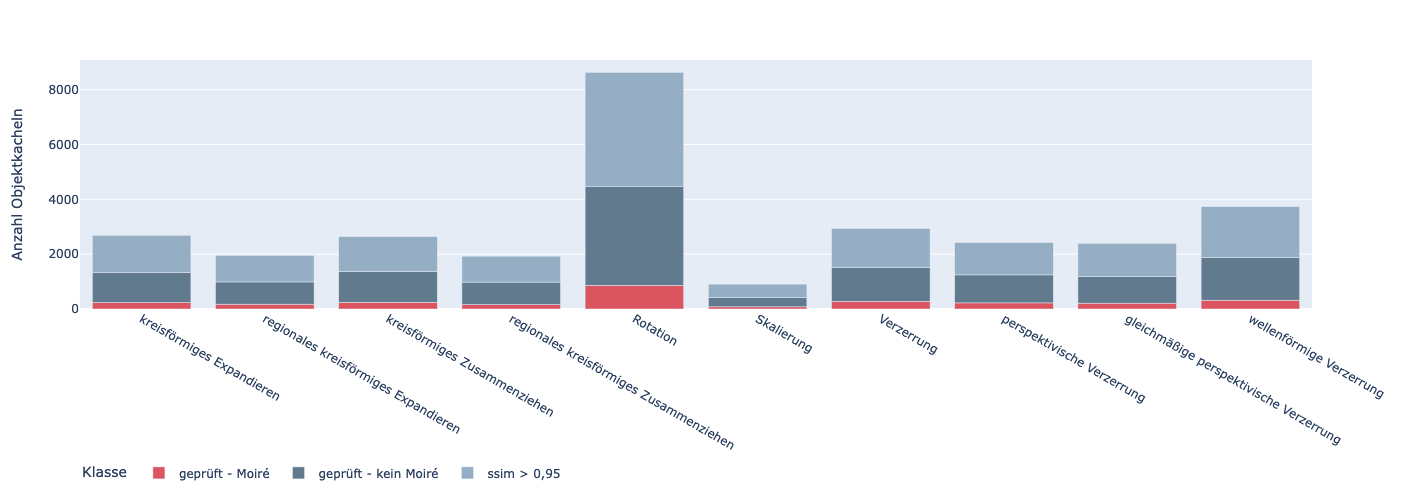

In [107]:
fig = px.bar(
    feature_probability.loc[
        :,
        ['checked_moire','checked_no_moire','ssim_no_moire']
    ].rename(
        columns={
            "checked_moire" : "geprüft - Moiré",
            "checked_no_moire" : "geprüft - kein Moiré",
            "ssim_no_moire" : 'ssim > 0,95'
        }
    ),
    width=800,
    height=500,
    labels={
        'value' : 'Anzahl Objektkacheln',
        'feature' : '',
        'index' : '',
        'variable' : 'Klasse'
    },
    color_discrete_map=COLOR_MAP
)
fig.update_layout(legend={
    'orientation':'h',
    'y' : -0.6,
})
#fig.update_xaxes(tickangle=90)
fig.write_image( attachment_dir / 'grouped_by_features.jpg' )
fig.write_image( attachment_dir / 'grouped_by_features.pdf' )

fig

In [ ]:
fig = px.bar(
    feature_probability.moire_rate,
    labels={
        "value" : 'Moirérate',
        'feature' : ''
    },
    color_discrete_sequence=COLOR_SEQUENCE
)
fig.update_layout(showlegend=False)
fig.write_image( attachment_dir / 'grouped_by_features_probability.jpg' )
fig.write_image( attachment_dir / 'grouped_by_features_probability.pdf' )

fig

Moirérate für Rotationskacheln ohne 45°

In [ ]:
group_by(
    masks.loc[
        (masks.mask_id.isin(data.loc[data.adjustment == 'rotation'].mask_id)) &
        (masks.mask_id.isin(feature_data.loc[feature_data.rotation_degree != 45].mask_id) == False)
    ],
    ['method']
)

7507              ssim > 0,95
7508     geprüft - kein Moiré
7511     geprüft - kein Moiré
7512              ssim > 0,95
7513              ssim > 0,95
                 ...         
18335    geprüft - kein Moiré
18336             ssim > 0,95
18337    geprüft - kein Moiré
18338             ssim > 0,95
18339    geprüft - kein Moiré
Name: label, Length: 9493, dtype: object

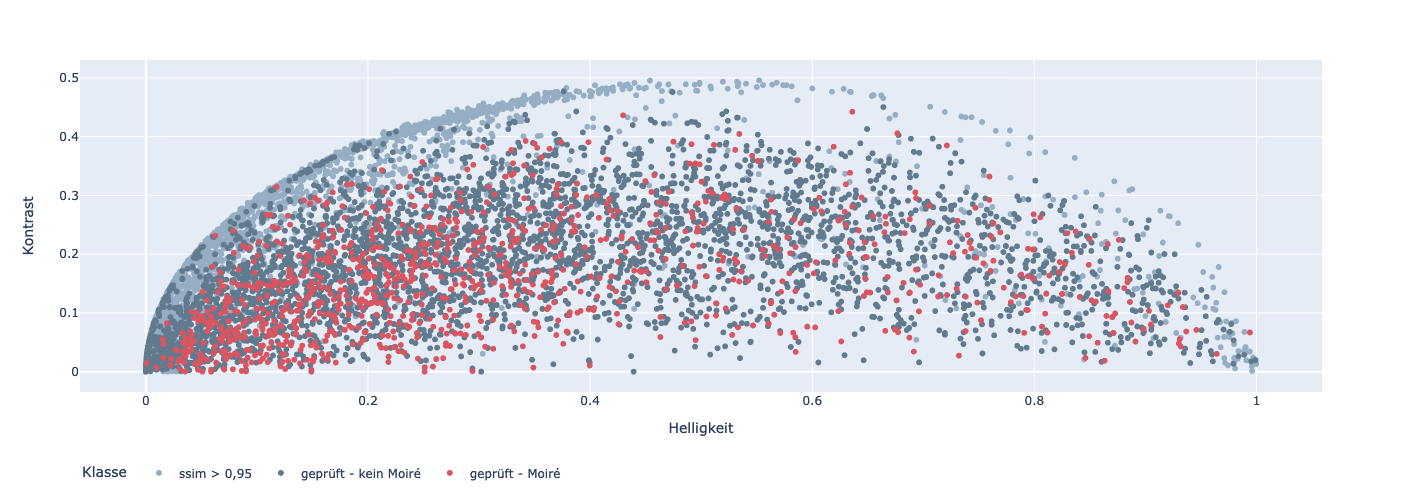

In [75]:
fig = px.scatter(
    x=masks.K_mean_coverage,
    y=masks.K_std_coverage,
    color=masks.label.replace(
        ['checked_moire','checked_no_moire','ssim_no_moire'],
        ['geprüft - Moiré','geprüft - kein Moiré','ssim > 0,95']
    ),
    color_discrete_map=COLOR_MAP,
    labels={
        'x' : 'Helligkeit',
        'y' : 'Kontrast',
        'color' : 'Klasse'
    },
    width=500,
    height=500
)
fig.update_layout(legend={'orientation':'h', 'y' : -0.2})
fig.write_image( attachment_dir / 'K_coverage.jpg' )
fig.write_image( attachment_dir / 'K_coverage.pdf' )


fig

# box blots

In [ ]:
feature_data = get_feature_importance_df( masks, data )

In [ ]:
fig_rotation = go.Figure().add_trace(go.Box(
    x=feature_data.rotation_degree,
    name='Winkel Rotation',
    boxpoints=False,
    marker_color=COLOR_SEQUENCE[0]
))
fig_rotation.update_layout(showlegend=False)

fig_rotation

In [ ]:
fig_stretch = go.Figure()
fig_stretch.add_trace(go.Box(
    x=feature_data.stretch_x,
    name='stretch_x',
    boxpoints=False,
    marker_color=COLOR_SEQUENCE[0]
))

fig_stretch.add_trace(go.Box(
    x=feature_data.stretch_y,
    name='stretch_y',
    boxpoints=False,
    marker_color=COLOR_SEQUENCE[0]
))
fig_stretch.update_layout(showlegend=False)

fig_stretch

In [ ]:
fig_distortion = go.Figure()
fig_distortion.add_trace(go.Box(
    x=feature_data.top_left_x,
    name='top_left_x',
    boxpoints=False,
    marker_color=COLOR_SEQUENCE[0]
))
fig_distortion.add_trace(go.Box(
    x=feature_data.top_left_y,
    name='top_left_y',
    boxpoints=False,
    marker_color=COLOR_SEQUENCE[0]
))
fig_distortion.add_trace(go.Box(
    x=feature_data.top_left_y,
    name='top_right_x',
    boxpoints=False,
    marker_color=COLOR_SEQUENCE[0]
))
fig_distortion.add_trace(go.Box(
    x=feature_data.top_left_y,
    name='top_right_y',
    boxpoints=False,
    marker_color=COLOR_SEQUENCE[0]
))
fig_distortion.add_trace(go.Box(
    x=feature_data.top_left_y,
    name='bottom_left_x',
    boxpoints=False,
    marker_color=COLOR_SEQUENCE[0]
))
fig_distortion.add_trace(go.Box(
    x=feature_data.top_left_y,
    name='bottom_left_y',
    boxpoints=False,
    marker_color=COLOR_SEQUENCE[0]
))
fig_distortion.add_trace(go.Box(
    x=feature_data.top_left_y,
    name='bottom_right_x',
    boxpoints=False,
    marker_color=COLOR_SEQUENCE[0]
))
fig_distortion.add_trace(go.Box(
    x=feature_data.top_left_y,
    name='bottom_right_y',
    boxpoints=False,
    marker_color=COLOR_SEQUENCE[0]
))

fig_distortion.update_layout(showlegend=False)

fig_distortion

## Korrelation nach Parametern

In [ ]:
feature_data.top_left_x.describe()

In [ ]:
px.box(feature_data.top_left_x)

In [ ]:
feature_data.loc[
    :,
    [c for c in feature_data.columns if c not in ['mask_id','pattern_shape','pattern_coverage','cover_style','label']]
].columns

In [ ]:
correlations = []

for c in feature_data.columns:        
    if c not in ['label','mask_id','ssim','overlay_intensity_K','pattern_shape','cover_style','pattern_coverage']:
        base_value = 0 if c not in ['stretch_x','stretch_y'] else 1
        y = (feature_data.loc[feature_data[c] != base_value].label == 'checked_moire').astype('int')
        
        X = feature_data.loc[
            feature_data[c] != base_value,
            c
        ].to_numpy()
        
        correlations.append((
            c,
            stats.pearsonr(X, y),
            stats.spearmanr(X,y)
        ))

In [ ]:
corr_frame = pd.DataFrame(
    [
        (corr[0],round(corr[1].statistic,3),round(corr[1].pvalue,3),round(corr[2].statistic,3),round(corr[2].pvalue,3))
        for corr in correlations
    ],
    columns=['feature','pearson_corr','pearson_p-value','spearman_corr','spearman_p-value']
).set_index('feature')

In [ ]:
fig = px.bar(
    corr_frame.loc[pd.isna(corr_frame.spearman_corr) == False].spearman_corr,
    color_discrete_sequence=COLOR_SEQUENCE,
    width=1650,
    height=500,
    labels={
        'value' : ''
    }
)
fig.update_layout(showlegend=False)
fig.write_image(attachment_dir / 'feature_values_correlation.jpg')
fig.write_image(attachment_dir / 'feature_values_correlation.pdf')

fig

## Rotation

In [ ]:
X = data.loc[
    data.adjustment == 'rotation'
].features.apply( lambda val: json.loads(val)['rotation_degree'] ).tolist()

y = label_encoder.transform(data.loc[
    data.adjustment == 'rotation'
].label.tolist())

stats.pearsonr(X, y)

In [ ]:
round(stats.pearsonr(X, y).pvalue,3)

In [ ]:
px.scatter(
    y=data.loc[
        data.adjustment == 'rotation'
    ].features.apply( lambda val: json.loads(val)['rotation_degree'] ),
    color=data.loc[
        data.adjustment == 'rotation'
    ].label,
    color_discrete_map=COLOR_MAP,
    labels={
        "x" : "Rotationseffekte",
        'y' : 'Winkel'
    }
).write_image( attachment_dir / 'rotation.jpg' )

## Skalierung

In [ ]:
from get_feature_importance_df import get_scale_data

In [ ]:
X = data.loc[
    data.adjustment == 'scale'
].features.apply( lambda val: json.loads(val)['scale'] ).tolist()

y = le.transform(data.loc[
    data.adjustment == 'scale'
].label.tolist())

stats.pearsonr(X, y)

In [ ]:
scale_data = pd.merge(
    get_scale_data( data ),
    data.loc[:,['mask_id','label']].drop_duplicates(),
    how="left",
    on="mask_id"
)

In [ ]:
fig = go.Figure()
fig.add_traces([
    go.Scatter(
        name='Upper Bound',
        x=scale_data.loc[scale_data.label == 'ssim_no_moire'].stretch_x,
        y=scale_data.loc[scale_data.label == 'ssim_no_moire'].stretch_y,
        mode='markers',
        marker=dict(color=COLOR_MAP['ssim_no_moire']),
        line=dict(width=1),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=scale_data.loc[scale_data.label == 'checked_no_moire'].stretch_x,
        y=scale_data.loc[scale_data.label == 'checked_no_moire'].stretch_y,
        line=dict(width=1),
        mode='markers',
        marker=dict(color=COLOR_MAP['checked_no_moire']),
        showlegend=False
    ),
    go.Scatter(
        x=scale_data.loc[scale_data.label == 'checked_moire'].stretch_x,
        y=scale_data.loc[scale_data.label == 'checked_moire'].stretch_y,
        mode='markers',
        marker=dict(color=COLOR_MAP['checked_moire']),
        showlegend=False
    )
])

fig.write_image( attachment_dir / 'skalierung.jpg' )

fig

# perspektivische Verzerrung

In [ ]:
px.scatter(
    y=data.loc[
        data.adjustment == 'uniform_trapezoidal_distortion'
    ].features.apply( lambda val: json.loads(val)['trapezoidal_distortion_strength'] ),
    color=data.loc[
        data.adjustment == 'uniform_trapezoidal_distortion'
    ].label == 'checked_moire'
)

In [ ]:
X = data.loc[
    data.adjustment == 'uniform_trapezoidal_distortion'
].features.apply( lambda val: json.loads(val)['trapezoidal_distortion_strength'] ).tolist()

y = le.transform(data.loc[
    data.adjustment == 'uniform_trapezoidal_distortion'
].label.tolist())

stats.pearsonr(X, y)

# Regression

In [110]:
from sklearn.inspection import permutation_importance

In [111]:
regression_data = get_feature_importance_df( masks, data )
regression_data.label = (regression_data.label == 'checked_moire').astype('int')

In [112]:
rows = []

for i in tqdm(range(1)):
    sample = regression_data.sample(frac=.8)

    X = sample.loc[
        :,
        [c for c in sample.columns if c not in ['label','mask_id','ssim']]
    ].to_numpy()
    y = sample.loc[:,'label'].to_numpy()

    clf = RandomForestClassifier(max_depth=10, random_state=0)
    clf.fit(X, y)

    row = {
        'score' : clf.score(X, y)
    }

    i = 0
    for c in regression_data.columns:        
        if c not in ['label','mask_id','ssim']:
            row[c] = clf.feature_importances_[i]
            i += 1

    rows.append(row)

  0%|          | 0/1 [00:00<?, ?it/s]

In [113]:
regression_test = regression_data.loc[
    regression_data.index.isin( sample.index ) == False
]

In [114]:
clf.score(X, y)

0.9190283400809717

In [115]:
clf.score(
    regression_test.loc[
        :,
        [c for c in regression_test.columns if c not in ['label','mask_id','ssim']]
    ].to_numpy(),
    regression_test.loc[:,'label'].to_numpy()
)

0.925280199252802

In [116]:
result = permutation_importance(clf, X, y, n_repeats=10,random_state=0)

In [129]:
[c for c in sample.columns if c not in rename_columns.keys()]

['mask_id',
 'ssim',
 'label',
 'top_left_x',
 'top_left_y',
 'bottom_left_x',
 'bottom_left_y',
 'bottom_right_x',
 'bottom_right_y',
 'top_right_x',
 'top_right_y',
 'blow_up_count',
 'blow_up_radius_1',
 'blow_up_center_x_1',
 'blow_up_center_y_1',
 'blow_up_c_1',
 'blow_up_radius_2',
 'blow_up_center_x_2',
 'blow_up_center_y_2',
 'blow_up_c_2',
 'blow_up_radius_3',
 'blow_up_center_x_3',
 'blow_up_center_y_3',
 'blow_up_c_3',
 'blow_up_radius_4',
 'blow_up_center_x_4',
 'blow_up_center_y_4',
 'blow_up_c_4',
 'blow_up_radius_5',
 'blow_up_center_x_5',
 'blow_up_center_y_5',
 'blow_up_c_5',
 'blow_up_radius_6',
 'blow_up_center_x_6',
 'blow_up_center_y_6',
 'blow_up_c_6',
 'blow_up_radius_7',
 'blow_up_center_x_7',
 'blow_up_center_y_7',
 'blow_up_c_7',
 'contract_count',
 'contract_radius_1',
 'contract_center_x_1',
 'contract_center_y_1',
 'contract_c_1',
 'contract_radius_2',
 'contract_center_x_2',
 'contract_center_y_2',
 'contract_c_2',
 'contract_radius_3',
 'contract_center_x

In [130]:
rename_columns = {
    'overlay_intensity_K' : 'Überlagerungsintensität',
    'K_mean_coverage' : 'Helligkeit',
    'K_std_coverage' : 'Kontrast',
    'pattern_shape' : 'Patterngrundform',
    'pattern_coverage' : 'Flächendeckung',
    'cover_style' : 'Flächendeckungsverteilung',
    'stretch_x' : 'Verzerrung x',
    'stretch_y' : 'Verzerrung y',
    'rotation_degree' : 'Rotationswinkel',
    'centered_c_blow_up' : 'c (kreisförmiges Expandieren)',
    'centered_c_contract' : 'c (kreisförmiges Zusammenziehen)',
    'top_left_x' : 'Verzerrung x (oben links)',
    'top_left_y' : 'Verzerrung y (oben links)',
    'bottom_left_x' : 'Verzerrung x (unten links)',
    'bottom_left_y' : 'Verzerrung y (unten links)',
    'bottom_right_x' : 'Verzerrung x (unten rechts)',
    'bottom_right_y' : 'Verzerrung y (unten rechts)',
    'top_right_x' : 'Verzerrung x (oben rechts)',
    'top_right_y' : 'Verzerrung y (oben rechts)',
}

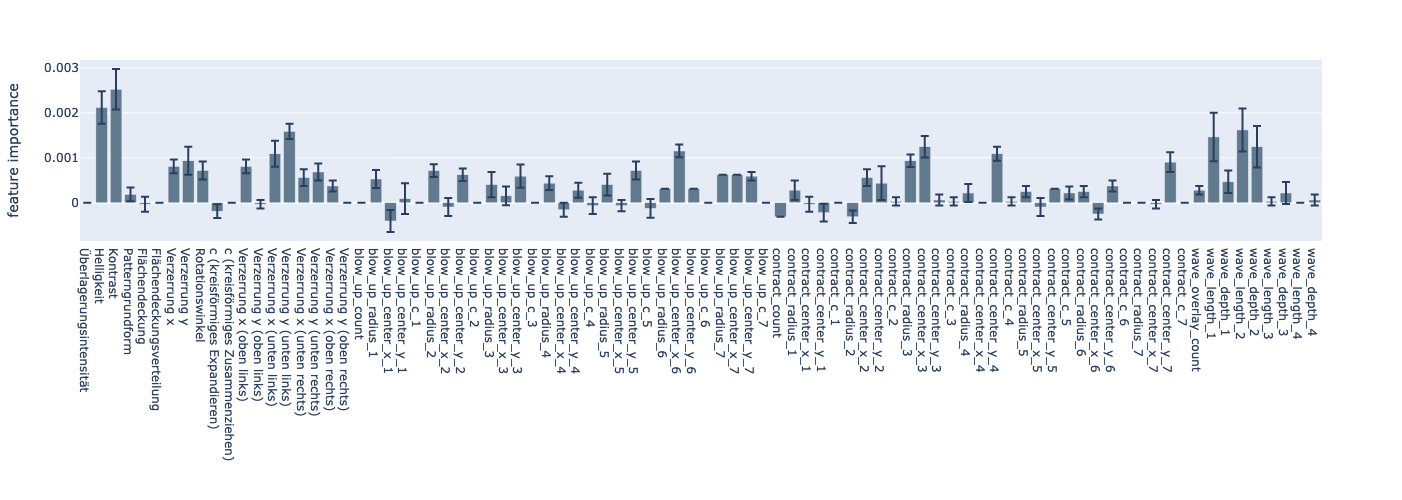

In [131]:
fig = px.bar(
    x=[rename_columns[c] if c in rename_columns.keys() else c for c in sample.columns if c not in ['label','mask_id','ssim']],
    y=result.importances_mean,
    error_y=result.importances_std,
    color_discrete_sequence=COLOR_SEQUENCE,
    width=1650,
    height=500,
    labels={
        'x' : '',
        'y' : 'feature importance'
    }
)

fig.write_image(attachment_dir / 'feature_importance.jpg')
fig.write_image(attachment_dir / 'feature_importance.pdf')

fig

# Clustering anhand der Regression Features

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer

In [ ]:
X = regression_data.loc[
    :,
    [c for c in sample.columns if c not in ['label','mask_id','ssim']]
].to_numpy()
transformer = Normalizer().fit(X)  # fit does nothing.
transformer
transformer.transform(X)    

y = regression_data.loc[:,'label'].to_numpy()

In [ ]:
results = []

for n_clusters in tqdm(range(2,50)):
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(X)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)

    results.append((
        n_clusters,
        silhouette_avg
    ))

    # Compute the silhouette scores for each sample
    #sample_silhouette_values = silhouette_samples(X, cluster_labels)

In [ ]:
silhouette_df = pd.DataFrame(results, columns=['n_clusters', 'silhouette_avg'])

In [ ]:
px.line(
    x=silhouette_df.n_clusters,
    y=silhouette_df.silhouette_avg
)

In [ ]:
n_clusters = silhouette_df.loc[
    silhouette_df.silhouette_avg == silhouette_df.silhouette_avg.max()
].n_clusters.iloc[0]

In [ ]:
clusterer = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(X)

In [ ]:
clusters = clusterer.predict(X)

In [ ]:
y[y == 1].shape[0] / y.shape[0]

In [ ]:
for c in tqdm(range(clusters.max() + 1)):
    relevant_idx = np.where(clusters == c)[0]
    labels_of_cluster = [y[i] for i in relevant_idx]
    purity = len([l for l in labels_of_cluster if l == 1]) / len(labels_of_cluster)

    print( c, purity )